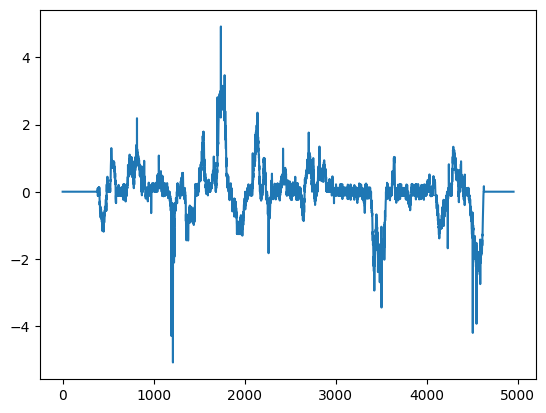

VVV 0.3029599894936305


In [1]:
import numpy as np

# Load the npz file
filePathE1 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Encoders20.npz"
data = np.load(filePathE1)


#counts for differnet wheels 
encoder_counts = data['counts']
FR = encoder_counts[0]
FL = encoder_counts[1]
RR = encoder_counts[2]
RL = encoder_counts[3]

L = (0.47625+0.31115)/2 #in meters
travel_per_tic = 0.0022

encoder_time_stamps = data['time_stamps']
#print(encoder_time_stamps.shape)
#print(encoder_time_stamps)

v_r = []
v_l = []
encoder_angular_velocity = []
v = []
for i in range(len(encoder_time_stamps)):
    tau = encoder_time_stamps[i]-encoder_time_stamps[i-1]
    d_r_i = ((FR[i]+RR[i])/2)*travel_per_tic
    v_r_i = d_r_i/tau
    v_r.append(v_r_i)
    d_l_i = ((FL[i]+RL[i])/2)*travel_per_tic
    v_l_i = d_l_i/tau
    v_l.append(v_l_i)
    omega_i = (v_r_i-v_l_i)/L
    encoder_angular_velocity.append(omega_i)
    v_i = (v_r_i+v_l_i)/2
    v.append(v_i)

import matplotlib.pyplot as plt
plt.plot(encoder_angular_velocity)
plt.show()

print("VVV",v[500])




In [2]:
# Load the npz file
filePathIMU20 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Imu20.npz"
data = np.load(filePathIMU20)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
print(data['angular_velocity'].shape)
yaw = data['angular_velocity'][2]
print(yaw)
imu_time_stamps = data['time_stamps']


#syncronize IMu with encoder
yaw_sync = []
for i in range(len(encoder_time_stamps)):
    e_time_stamp = encoder_time_stamps[i]
    l_diff = 10
    corr_time_stamp_index = 0
    for j in range(len(imu_time_stamps)):
        i_time_stamp = imu_time_stamps[j]
        diff = abs(e_time_stamp-i_time_stamp)
        if diff<l_diff:
            #print("gg")
            l_diff = diff
            #print(diff)
            corr_time_stamp_index = j
    corr_imu_val = yaw[corr_time_stamp_index]
    yaw_sync.append(corr_imu_val)




Keys in the npz file:
['angular_velocity', 'linear_acceleration', 'time_stamps']
[array([[ 0.00658551,  0.00424913,  0.00279578, ..., -0.00227567,
        -0.00624112, -0.01028513],
       [-0.00578402, -0.00286166, -0.00025825, ..., -0.00183984,
        -0.00542604, -0.00655069],
       [ 0.00490467,  0.00208956, -0.00030337, ...,  0.00427145,
         0.00483386,  0.00511853]]), array([[ 6.24603149e-04,  8.68602488e-05, -4.14567382e-04, ...,
        -1.28033057e-02, -1.27858161e-02, -1.27722843e-02],
       [-1.61259512e-02, -1.61229602e-02, -1.61197752e-02, ...,
        -1.41738861e-02, -1.42381361e-02, -1.43159987e-02],
       [ 1.02199933e+00,  1.02154318e+00,  1.02111573e+00, ...,
         1.01423169e+00,  1.01437542e+00,  1.01450887e+00]]), array([1.29844527e+09, 1.29844527e+09, 1.29844527e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])]
(3, 12187)
[ 0.00490467  0.00208956 -0.00030337 ...  0.00427145  0.00483386
  0.00511853]


In [3]:
e_ind = []
for i in range(len(encoder_time_stamps)):
    e_ind_i = [encoder_time_stamps[i],"e",i]
    e_ind.append(e_ind_i)
print(len(e_ind))
imu_ind = []
for i in range(len(imu_time_stamps)):
    imu_ind_i = [imu_time_stamps[i],"imu",i]
    imu_ind.append(imu_ind_i)
print(len(imu_ind))
all_time_stamps_with_indicies = e_ind + imu_ind
sorted_time_stamps = sorted(all_time_stamps_with_indicies, key = lambda x: x[0])
#print(sorted_time_stamps)

imu_sync = []
for i in range(len(encoder_time_stamps)):
    e_time_stamp = encoder_time_stamps[i]
    
    for j in range(len(sorted_time_stamps)):
        if sorted_time_stamps[j][0] == e_time_stamp and sorted_time_stamps[j][1] == "e":
            sorted_index = j
    for t in range(sorted_index,len(sorted_time_stamps)):
        if sorted_time_stamps[t][1] == "imu":
            ind = sorted_time_stamps[t][2]
            imu_val = yaw[ind]
            imu_sync.append(imu_val)
            break
    if len(imu_sync) < i:##to get same length on imu_sync as encoder
        imu_sync.append(0)
imu_sync.append(0) ##to get same length on imu_sync as encoder

print(len(imu_sync))


4956
12187
4956


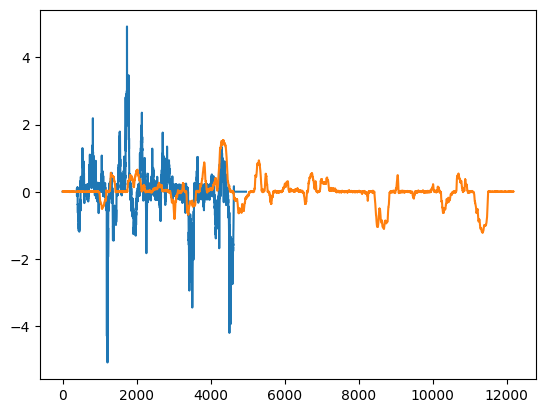

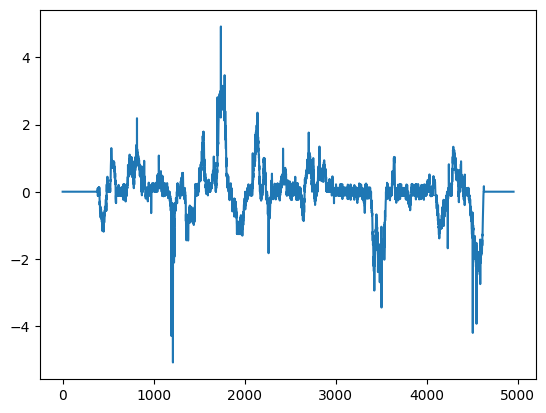

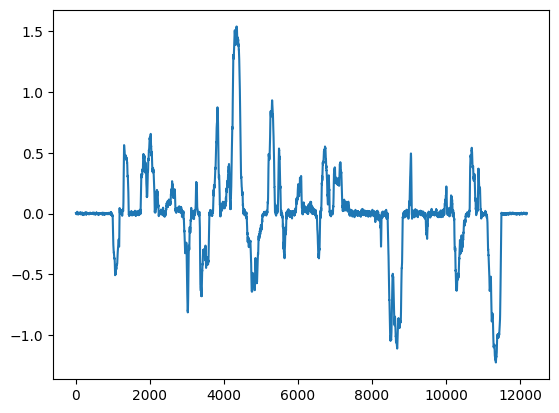

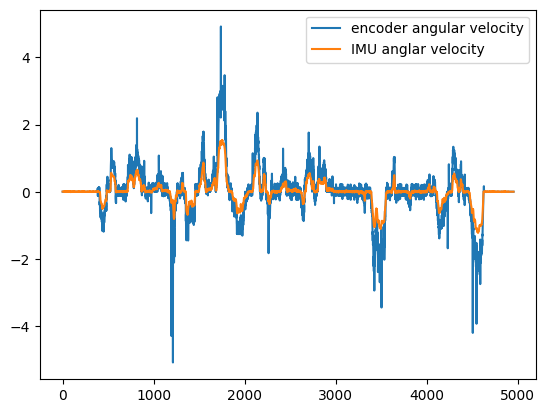

In [4]:
import matplotlib.pyplot as plt
plt.plot(encoder_angular_velocity)
plt.plot(yaw)
plt.show()
plt.plot(encoder_angular_velocity)
plt.show()
plt.plot(yaw)
plt.show()
plt.plot(encoder_angular_velocity)
plt.plot(imu_sync)
plt.legend(["encoder angular velocity", "IMU anglar velocity"])
plt.show()
#print(yaw_sync)

In [5]:
from scipy.integrate import quad
#Differentila-drive kinematic Model
x_0 = np.array([0,0,0])
x = []
x.append(x_0)
for t in range(1,len(encoder_time_stamps)):
    tau = encoder_time_stamps[t]-encoder_time_stamps[t-1]
    omega = imu_sync[t-1]
    #theta = quad(omega,0,tau)
    #theta = omega*tau #simple integratino of angular velocity to find thea 
    theta = x[t-1][2]
    x_t = x[t-1]+ tau*np.array([v[t-1]*np.cos(theta),v[t-1]*np.sin(theta),omega])
    x.append(x_t)
print(len(x))
#print(x)

# Initialize empty lists for each element position
x_only = []
y_only = []
theta_only = []

# Iterate over the list of arrays and append each element to the appropriate list
x_pose = x

for array in x:
    x_only.append(array[0])
    y_only.append(array[1])
    theta_only.append(array[2])
    

4956


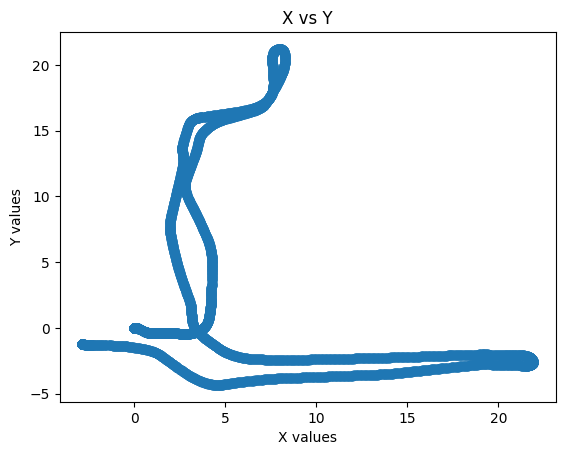

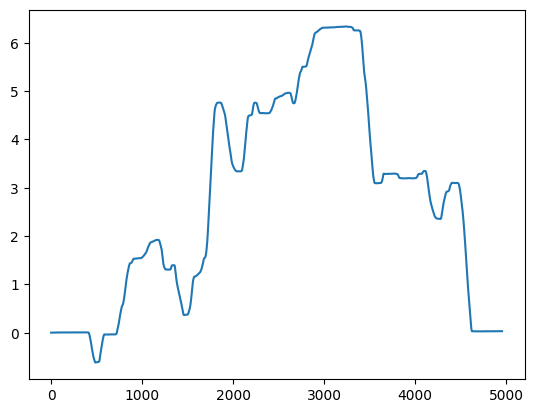

In [6]:
import matplotlib.pyplot as plt

#print(y_only)

# Create a scatter plot of the x and y values
plt.scatter(x_only, y_only)

# Set the x and y axis labels
plt.xlabel("X values")
plt.ylabel("Y values")

# Set the title of the plot
plt.title("X vs Y")

# Show the plot
plt.show()

plt.plot(theta_only)
plt.show()


In [7]:
import numpy as np

# Load the npz file
filePathE2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Encoders21.npz"
data = np.load(filePathE2)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
print(data['counts'].shape)


Keys in the npz file:
['counts', 'time_stamps']
[array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int16), array([1.29888199e+09, 1.29888200e+09, 1.29888200e+09, ...,
       1.29888211e+09, 1.29888211e+09, 1.29888211e+09])]
(4, 4789)


In [8]:




# Load the npz file
filePathH2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Hokuyo20.npz"
data = np.load(filePathH2)

# Print the keys of the npz file
print("Keys in the npz file:")
#print(data.keys())
print(list(data.keys()))
print(list(data.values()))
#print(data['counts'].shape)

lidar_time_stamps = data['time_stamps']
print(lidar_time_stamps.shape)
print(data['ranges'].shape)
print(data['angle_increment'])
initial_scan_ranges = data['ranges'][:,0]
print(initial_scan_ranges.shape)
angle_increment = data['angle_increment'][0][0]
print("inc,",angle_increment)
angle_min = data['angle_min']
angle_max = data['angle_max']
lidar_ranges = data['ranges']

total_angle =  (3/2)*np.pi

angles = np.linspace(angle_min,angle_max,num=1081)

ranges = data['ranges']
print(ranges.shape)


Keys in the npz file:
['angle_min', 'angle_max', 'angle_increment', 'range_min', 'range_max', 'ranges', 'time_stamps']
[array(-2.35619449), array(2.35619449), array([[0.00436332]]), array(0.1), array(30), array([[3.375     , 3.38899994, 3.39400005, ..., 3.01300001, 3.02900004,
        3.02999997],
       [3.375     , 3.39299989, 3.39899993, ..., 3.06500006, 3.06200004,
        3.06900001],
       [3.38199997, 3.41700006, 3.39899993, ..., 3.079     , 3.08299994,
        3.07800007],
       ...,
       [4.90999985, 4.92399979, 4.91900015, ..., 1.83399999, 1.824     ,
        1.84099996],
       [4.90999985, 4.92399979, 4.91900015, ..., 1.829     , 1.81299996,
        1.82200003],
       [4.90999985, 4.92399979, 4.91900015, ..., 1.829     , 1.81299996,
        1.80700004]]), array([1.29844527e+09, 1.29844527e+09, 1.29844527e+09, ...,
       1.29844540e+09, 1.29844540e+09, 1.29844540e+09])]
(4962,)
(1081, 4962)
[[0.00436332]]
(1081,)
inc, 0.004363323129985824
(1081, 4962)


In [9]:
#think this is worng 
import pr2_utils as utils

MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  20
MAP['ymax']  =  20 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64) #DATA TYPE: char or int8

#remove measurments outside range(0.1,30)
indValid = np.logical_and((initial_scan_ranges < 30),(initial_scan_ranges> 0.1))
initial_scan_ranges = initial_scan_ranges[indValid]
angles = angles[indValid]

#start points of lidar ray in lidar frame
sx = np.ceil((x_only[0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
sy = np.ceil((y_only[0] - MAP['ymin']) / MAP['res']).astype(np.int16)-1

#end points of lidar ray in lidar frame 
ex = initial_scan_ranges*np.cos(angles)
ey = initial_scan_ranges*np.sin(angles)
print(ex.shape)

x_length_from_lidar_to_body_center = 0.29833/2
z_length_from_lidar_to_body_center = 0.51435

rTl1 = np.array([[1,0,0,-x_length_from_lidar_to_body_center],
               [0,1,0,0],
               [0,0,1,-z_length_from_lidar_to_body_center],
               [0,0,0,1]])

rTl = np.array([[1,0,-x_length_from_lidar_to_body_center],
                [0,1,0],
                [0,0,1]])
#print(rTl)

#exyz = np.ones((4,np.size(ex))) #np.zeros?
#exyz[0, :] = ex
#exyz[1,:] = ey
#print(exyz.shape)

exy = np.ones((3,np.size(ex))) #np.zeros?
exy[0, :] = ex
exy[1,:] = ey

#transform to body frame
exyz = np.dot(rTl,exy)
#print(exyz.shape)

def worldTbody1(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),0,x],
                    [np.sin(theta),np.cos(theta),0,y],
                    [0,0,1,0],
                    [0,0,0,1]])
    return wTb

def worldTbody(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                    [np.sin(theta),np.cos(theta),y],
                    [0,0,1]])
    return wTb
    

wTb1 = worldTbody(x[0][0],x[0][1],x[0][2])
#print(wTb0)

#transform to world frame
#exyz_w = np.dot(wTb0,exyz)
exy_w = np.dot(wTb1,exy)
print(exy_w.shape)







(1078,)
(3, 1078)


In [10]:
import pr2_utils as utils

MAP = {}
MAP['res']   = 0.05 #meters
MAP['xmin']  = -20  #meters
MAP['ymin']  = -20
MAP['xmax']  =  20
MAP['ymax']  =  20 
MAP['sizex']  = int(np.ceil((MAP['xmax'] - MAP['xmin']) / MAP['res'] + 1)) #cells
MAP['sizey']  = int(np.ceil((MAP['ymax'] - MAP['ymin']) / MAP['res'] + 1))
MAP['map'] = np.zeros((MAP['sizex'],MAP['sizey']),dtype=np.float64) #DATA TYPE: char or int8

#remove measurments outside range(0.1,30)
indValid = np.logical_and((initial_scan_ranges < 30),(initial_scan_ranges> 0.1))
initial_scan_ranges = initial_scan_ranges[indValid]
angles = angles[indValid]

#start points of lidar ray in lidar frame
sx = np.ceil((x_only[0] - MAP['xmin']) / MAP['res']).astype(np.int16)-1
sy = np.ceil((y_only[0] - MAP['ymin']) / MAP['res']).astype(np.int16)-1

#end points of lidar ray in lidar frame 
ex = initial_scan_ranges*np.cos(angles)
ey = initial_scan_ranges*np.sin(angles)
print(ex.shape)

x_length_from_lidar_to_body_center = 0.29833/2
z_length_from_lidar_to_body_center = 0.51435

rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                [0,1,0],
                [0,0,1]])
#print(rTl)

exy = np.zeros((3,np.size(ex))) #np.zeros?
exy[0, :] = ex
exy[1,:] = ey

#transform to body frame
exy = np.dot(rTl,exy)

def worldTbody(x,y,theta):
    wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                    [np.sin(theta),np.cos(theta),y],
                    [0,0,1]])
    return wTb
    

wTb0 = worldTbody(x[0][0],x[0][1],x[0][2])
#print(wTb0)

#transform to world frame
#exyz_w = np.dot(wTb0,exyz)
exy_w = np.dot(wTb0,exy)
print(exy_w.shape)







(1078,)
(3, 1078)


In [11]:
print(exy_w)

[[-2.38648539 -2.3760497  -2.37047511 ... -3.44146438 -3.45671219
  -3.47189419]
 [-2.38648539 -2.39687564 -2.412213   ...  3.5020596   3.48701009
   3.47189419]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


(1078,)
(1078,)
ind [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
de [-1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436
 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436 -1.38629436]
ind [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  Tr

/var/folders/pd/j077h3nd74d5kqhjn0jk727m0000gn/T/ipykernel_3313/2543200298.py:35: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Text(0.5, 1.0, 'Occupancy grid map')

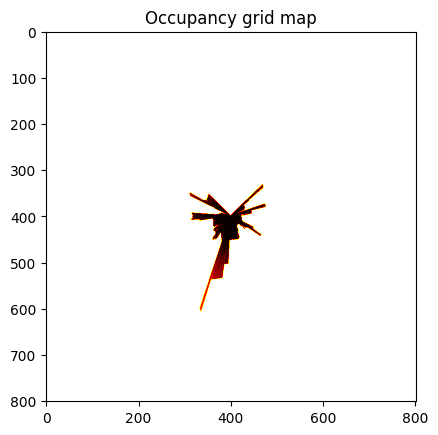

In [12]:
#convert end points to cells 
ex = exy_w[0, :] 
ey  = exy_w[1,:]
print(ey.shape)
ex = np.ceil((ex - MAP['xmin']) / MAP['res']).astype(np.int16)-1
ey = np.ceil((ey - MAP['ymin']) / MAP['res']).astype(np.int16)-1
print(ey.shape)

for i in range(np.size(initial_scan_ranges)):
    bresenham_points = utils.bresenham2D(sx, sy, ex[i], ey[i])
    #print(bresenham_points)
    bresenham_points_x = bresenham_points[0, :].astype(np.int16)
    bresenham_points_y = bresenham_points[1, :].astype(np.int16)
    #print(bresenham_points_x.shape)
    #print(bresenham_points_y.shape)

    indGood = np.logical_and(
        np.logical_and(np.logical_and((bresenham_points_x > 1), (bresenham_points_y > 1)), (bresenham_points_x < MAP['sizex'])), (bresenham_points_y < MAP['sizey']))
    print("ind",indGood)
    # Decrease log-odds if cell is free
    MAP['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]] -= np.log(4)
   #print("bresh", bresenham_points_x[indGood] )
    print("de", MAP['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]])

    # Increase log-odds if cell is occupied
    if ((ex[i] > 1) and (ex[i] < MAP['sizex']) and (ey[i] > 1) and (ey[i] < MAP['sizey'])):
        MAP['map'][ex[i], ey[i]] += np.log(4)
        #print("ex", ex[i], "ey", ey[i])
        #print("inc", MAP['map'][ex[i], ey[i]].shape)

    # clip range to prevent over-confidence
#MAP['map'] = np.clip(MAP['map'], -10*np.log(4), 10*np.log(4))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print(MAP['map'])
fig2 = plt.figure()
plt.imshow(sigmoid(MAP['map']), cmap = 'hot');
plt.title("Occupancy grid map")

(801, 801)
(801,)


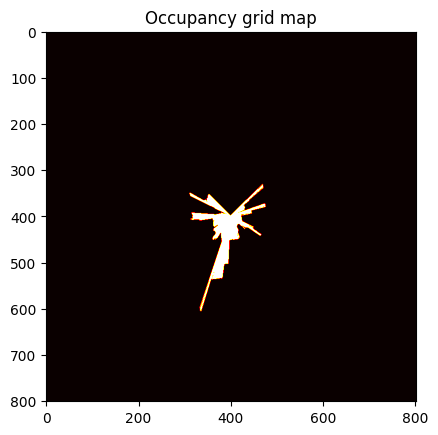

In [13]:
OMAP = {}
OMAP['res']   = 0.05 #meters
OMAP['xmin']  = -20  #meters
OMAP['ymin']  = -20
OMAP['xmax']  =  20
OMAP['ymax']  =  20 
OMAP['sizex']  = int(np.ceil((OMAP['xmax'] - OMAP['xmin']) / OMAP['res'] + 1)) #cells
OMAP['sizey']  = int(np.ceil((OMAP['ymax'] - OMAP['ymin']) / OMAP['res'] + 1))
OMAP['map'] = np.zeros((OMAP['sizex'],OMAP['sizey']),dtype=np.int8) #DATA TYPE: char or int8

print(OMAP['map'].shape)
print(MAP['map'][0].shape)
for x in range(MAP['map'].shape[0]):
    for y in range(MAP['map'].shape[1]):
        #print("map_val",MAP['map'][x,y])
        if MAP['map'][x,y] < 0:
            OMAP['map'][x,y] = 1
            
        else:
            #print("gg")
            OMAP['map'][x,y] = 0

fig3 = plt.figure()
plt.imshow(OMAP['map'],cmap="hot");
plt.title("Occupancy grid map")


def update_omap(OMAP,MAP):
    for x in range(MAP['map'].shape[0]):
        for y in range(MAP['map'].shape[1]):
        #print("map_val",MAP['map'][x,y])
            if MAP['map'][x,y] < 0:
                OMAP['map'][x,y] = 1
            
            else:
            #print("gg")
                OMAP['map'][x,y] = 0
    return OMAP


In [14]:

angles = np.linspace(angle_min, angle_max, num=1081)
def update_map(MAP, pose, ranges, angles):
    map = MAP.copy()
    #remove measurments outside range(0.1,30)
    indValid = np.logical_and((ranges < 30), (ranges > 0.1))
    ranges =ranges[indValid]
    angles = angles[indValid]
    x = pose[0]
    y = pose[1]
    thet = pose[2]

    x_length_from_lidar_to_body_center = 0.29833 / 2

    rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                    [0,1,0],
                    [0,0,1]])
    
    lTr = np.array([[1,0,-x_length_from_lidar_to_body_center],
                   [0,1,0],
                   [0,0,1]])
    
    #def bodyTworld(x,y,theta):
       # bTw = np.array([[np.cos(theta),np.sin(theta),-np.cos(theta)*x-np.sin(theta)*y],
                        #[-np.sin(theta),np.cos(theta),np.sin(theta)*x-np.cos(theta)*y],
                        #[0,0,1]])
        #return bTw
    
    #bTw0 = bodyTworld(x,y,thet)
    
    #wxy = np.array([x,y,thet])
    #bxy = np.dot(bTw0,wxy)
    #lxy = np.dot(lTr,bxy)
    #lxy = np.dot(lTr,wxy)
    #lx = lxy[0]
    #ly = lxy[1]

    

    #start points of lidar ray in lidar frame
    sxu = np.ceil((x - map['xmin']) / map['res']).astype(np.int16)-1
    syu = np.ceil((y - map['ymin']) / map['res']).astype(np.int16)-1
    #sxu = np.ceil((lx - map['xmin']) / map['res']).astype(np.int16)-1
    #syu = np.ceil((ly - map['ymin']) / map['res']).astype(np.int16)-1

    #end points of lidar ray in lidar frame 
    exu =ranges*np.cos(angles)
    eyu =ranges*np.sin(angles)
    #print(ex.shape)

    
    #print(rTl)

    exyu = np.zeros((3,np.size(exu))) #np.zeros?
    exyu[0, :] = exu
    exyu[1,:] = eyu

    #transform to body frame
    exyu = np.dot(rTl,exyu)

    def worldTbody(x,y,theta):
        wTb = np.array([[np.cos(theta),-np.sin(theta),x],
                        [np.sin(theta),np.cos(theta),y],
                        [0,0,1]])
        return wTb
        

    wTb0 = worldTbody(x,y,thet)
    #print(wTb0)

    #transform to world frame
    #exyz_w = np.dot(wTb0,exyz)
    exyu_w = np.dot(wTb0,exyu)
    #print(exy_w.shape)

    #convert end points to cells 
    exu = exyu_w[0, :] 
    eyu  = exyu_w[1,:]
    #print(ey.shape)
    exu = np.ceil((exu - map['xmin']) / map['res']).astype(np.int16)-1
    eyu = np.ceil((eyu - map['ymin']) / map['res']).astype(np.int16)-1
    #print(ey.shape)

    
    for i in range(np.size(ranges)):
        bresenham_points = utils.bresenham2D(sxu, syu, exu[i], eyu[i])
        bresenham_points_x = bresenham_points[0, :].astype(np.int16)
        bresenham_points_y = bresenham_points[1, :].astype(np.int16)
    

        indGood = np.logical_and(
            np.logical_and(np.logical_and((bresenham_points_x > 1), (bresenham_points_y > 1)), (bresenham_points_x < map['sizex'])), (bresenham_points_y < map['sizey']))
        # Decrease log-odds if cell is free
        map['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]] -= np.log(4)
        #print("de", map['map'][bresenham_points_x[indGood], bresenham_points_y[indGood]])

    # Increase log-odds if cell is occupied
    if ((exu[i] > 1) and (exu[i] < map['sizex']) and (eyu[i] > 1) and (eyu[i] < map['sizey'])):
        map['map'][exu[i], eyu[i]] += np.log(4)
        #print("ex", ex[i], "ey", ey[i])
        #print("inc", MAP['map'][ex[i], ey[i]].shape)

    # clip range to prevent over-confidence
    map['map'] = np.clip(map['map'], -10*np.log(4), 10*np.log(4))
    return map

In [15]:
# Load the npz file
filePathH2 = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/Hokuyo20.npz"
data = np.load(filePathH2)
print(data['ranges'].shape)

(1081, 4962)


(1081,)
4956


4956it [10:06,  8.18it/s]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Text(0.5, 1.0, 'Occupancy grid map')

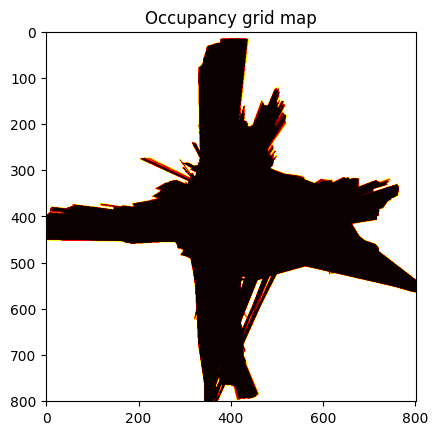

In [16]:
from tqdm import tqdm

angles = np.linspace(angle_min, angle_max, num=1081)
print(angles.shape)
print(len(x_pose))

MAP1 = MAP.copy()

for index,pose in tqdm(enumerate(x_pose)):
    #print(pose)
    ranges =  data['ranges'][:, index]
    MAP1 = update_map(MAP1,pose,ranges,angles)
    #OMAP = update_omap(OMAP,MAP1)
    #print("iteration:", index)

print(MAP['map'])
fig2 = plt.figure()
plt.imshow(sigmoid(MAP1['map']), cmap = 'hot');
plt.title("Occupancy grid map")

    

Text(0.5, 1.0, 'Occupancy grid map')

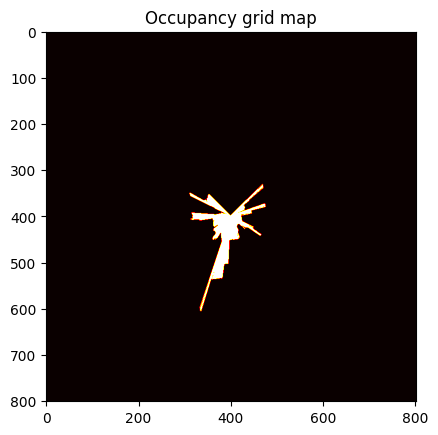

In [17]:
fig3 = plt.figure()
plt.imshow(OMAP['map'],cmap="hot");
plt.title("Occupancy grid map")

In [18]:
def init_particles(N):
  particle_state = np.zeros((3,N))
  particle_weight = np.zeros((1,N))
  particle_weight[0, 0:N] = 1 / N
  return particle_state,particle_weight


def prediction(particle_state, tau, v_t, w_t):
    N = np.shape(particle_state)[1]
    state = particle_state
    x_w = particle_state[0,:]
    y_w = particle_state[1,:]
    #print(y_w)
    theta_w = state[2,:]
    delta_x = tau * v_t * np.cos(theta_w)
    delta_y = tau * v_t * np.sin(theta_w)
    #print(delta_y)
    x_w += delta_x
    y_w += delta_y
    theta_w += tau * w_t
    #print("X_W",x_w)

    # Add noise 
    noise_x = np.random.normal(0, abs(np.max(delta_x)) / 10, N)
    noise_y = np.random.normal(0, abs(np.max(delta_y)) / 10, N)
    noise_theta = np.random.normal(0, abs(tau*w_t)/10, N)

    state[0, :] = x_w + noise_x
    state[1, :] = y_w + noise_y
    state[2, :] = theta_w + noise_theta
    print("p", state[0, 0])
    return state

In [19]:

state_list = np.zeros([4956, 3, 10])

N = 10

state_0, weights = init_particles(N)
#print("=",state_0)
state_list[0] = state_0
#print(state_list)
#print(np.shape(state_list)[0])
for t in range(1,len(encoder_time_stamps)):
    tau = encoder_time_stamps[t] - encoder_time_stamps[t-1]
    w = imu_sync[t-1]
    #print(state_list[t])
    state_t = prediction(state_list[t-1].copy(), tau, v[t-1], w)
    #print("state", state_t)
    state_list[t] = state_t
#print("state_t",state_t)
#print("state_list",state_list[0])
#print("state_list",state_list[4000])
#print("len,",len(state_list))
#print(state_list)
    

p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.0
p 0.

In [20]:
for t in range(state_list.shape[0]):
    print(state_list[t, 0, 0])

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [21]:
state_list.T.shape

(10, 3, 4956)

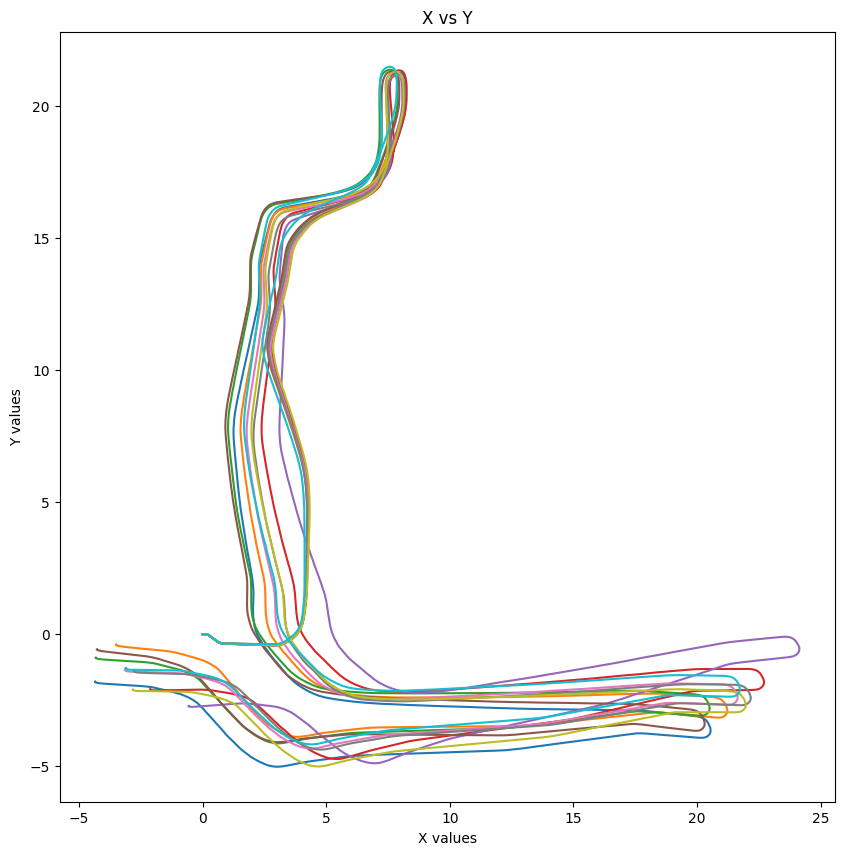

In [22]:
plt.subplots(1, 1, figsize=(10, 10))
plt.xlabel("X values")
plt.ylabel("Y values")

# Set the title of the plot
plt.title("X vs Y")
for p in range(state_list.shape[2]):
    plt.plot(state_list[:, 0, p], state_list[:, 1, p])

In [27]:
from pr2_utils import mapCorrelation

def softmax(x):
    e_x = np.exp(x-np.max(x))
    return e_x / np.sum(e_x)


def update(OMAP,MAP, particle_state, particle_weight, ranges, angles, N):

    # Binary map for map correlation
    map1 = update_omap(OMAP,MAP)
    map = map1['map']

    x_im = np.arange(MAP['xmin'], MAP['xmax'] + MAP['res'], MAP['res'])  # x index of each pixel on log-odds map
    y_im = np.arange(MAP['ymin'], MAP['ymax'] + MAP['res'], MAP['res'])  # y index of each pixel on log-odds map

    # Grid around particle
    x_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # x deviation
    y_range = np.arange(-4 * MAP['res'], 5 * MAP['res'], MAP['res'])  # y deviation

    


    rTl = np.array([[1,0,x_length_from_lidar_to_body_center],
                    [0,1,0],
                    [0,0,1]])
    
   
    

    #end points of lidar ray in lidar frame 
    exu =ranges*np.cos(angles)
    eyu =ranges*np.sin(angles)
    #print(ex.shape)


    exyu = np.zeros((3,np.size(exu))) #np.zeros?
    exyu[0, :] = exu
    exyu[1,:] = eyu

    #transform to body frame
    exyu = np.dot(rTl,exyu)

    correlation = np.zeros(N)
    

    for i in range(N):
        
        x_t = particle_state[:, i]
        x_w = x_t[0]
        y_w = x_t[1]
        theta_w = x_t[2]

        # Transform to world frame
        wTb0 = worldTbody(x_w,y_w,theta_w)
  

    
        s_w = np.dot(wTb0,exyu)
        ex_w = s_w[0, :]
        ey_w = s_w[1, :]
        Y = np.stack((ex_w, ey_w))

        c = mapCorrelation(map, x_im, y_im, Y, x_range, y_range)

        correlation[i] = np.max(c)

    # Update particle weight with softmax
    p_h = softmax(correlation)
    particle_weight *= p_h / np.sum(particle_weight * p_h)
    return particle_state, particle_weight



In [28]:

MAP2 = MAP.copy()
OMAP2 = OMAP.copy()

for t in range(1,len(encoder_time_stamps)):
    tau = encoder_time_stamps[t] - encoder_time_stamps[t-1]
    w = imu_sync[t-1]
    #print(state_list[t])
    ranges =  data['ranges'][:, t]
    state_t = prediction(state_list[t-1].copy(), tau, v[t-1], w)
    state_list[t] = state_t
    MAP2 = update(OMAP2,MAP2,state_t,weights,ranges,angles,N)
    #print("state", state_t)
    

p 0.0
p 0.0


TypeError: tuple indices must be integers or slices, not str

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

disp_path = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/Disparity20/"
rgb_path = "/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/RGB20/"

def normalize(img):
  max_ = img.max()
  min_ = img.min()
  return (img - min_)/(max_-min_)

if __name__ == '__main__':

  # load RGBD image
  imd = cv2.imread(disp_path+'disparity20_1.png',cv2.IMREAD_UNCHANGED) # (480 x 640)
  imc = cv2.imread(rgb_path+'rgb20_1.png')[...,::-1] # (480 x 640 x 3)

  print(imc.shape)

  # convert from disparity from uint16 to double
  disparity = imd.astype(np.float32)

  # get depth
  dd = (-0.00304 * disparity + 3.31)
  z = 1.03 / dd

  # calculate u and v coordinates 
  v,u = np.mgrid[0:disparity.shape[0],0:disparity.shape[1]]
  #u,v = np.meshgrid(np.arange(disparity.shape[1]),np.arange(disparity.shape[0]))

  # get 3D coordinates 
  fx = 585.05108211
  fy = 585.05108211
  cx = 315.83800193
  cy = 242.94140713
  x = (u-cx) / fx * z
  y = (v-cy) / fy * z

  # calculate the location of each pixel in the RGB image
  rgbu = np.round((u * 526.37 + dd*(-4.5*1750.46) + 19276.0)/fx)
  rgbv = np.round((v * 526.37 + 16662.0)/fy)
  valid = (rgbu>= 0)&(rgbu < disparity.shape[1])&(rgbv>=0)&(rgbv<disparity.shape[0])

  # display valid RGB pixels
  fig = plt.figure(figsize=(10, 13.3))
  ax = fig.add_subplot(projection='3d')
  ax.scatter(z[valid],-x[valid],-y[valid],c=imc[rgbv[valid].astype(int),rgbu[valid].astype(int)]/255.0)
  ax.set_xlabel('X')
  ax.set_ylabel('Y')
  ax.set_zlabel('Z')
  ax.view_init(elev=0, azim=180)
  plt.show()

  # display disparity image
  plt.imshow(normalize(imd), cmap='gray')
  plt.show()

[ WARN:0@42.958] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/Disparity20/disparity20_1.png'): can't open/read file: check file path/integrity
[ WARN:0@42.959] global /Users/xperience/actions-runner/_work/opencv-python/opencv-python/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('/Users/henrikstoklandberg/Documents/UCSD/ECE276A/ECE276A_PR2//data/dataRGBD/RGB20/rgb20_1.png'): can't open/read file: check file path/integrity


TypeError: 'NoneType' object is not subscriptable